## Data Analysis and Preprocessing

## Functions

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from tableone import TableOne
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from keras.layers import Dense, LSTM, Bidirectional, Dropout
from keras.models import Sequential
import tensorflow as tf

Functions that modify the Datasets

In [2]:
def impute_missing(data_sensors, column):
    before_imputation = data_sensors.copy()

    for index, row in data_sensors.iterrows():
        if pd.isna(row[column]):
            #prev row
            prev = data_sensors.loc[:index].loc[~data_sensors[column].isna()].tail(1)
            #next row
            next = data_sensors.loc[index:].loc[~data_sensors[column].isna()].head(1)

            if not (prev.empty or next.empty):
                mean = round((prev[column].values[0] + next[column].values[0]) / 2, 2)
                data_sensors.at[index, column] = mean

    
    changes = pd.DataFrame(columns=['Index', 'before', 'after'])
    for index, row in before_imputation.iterrows():
        before = row[column]
        after = data_sensors.at[index, column]
        if pd.notna(before) and pd.notna(after) and before != after:
            changes = changes.append({'Index': index, 'before': before, 'after': after}, ignore_index=True)

    return data_sensors, changes

def rename_sensor(data_sensors):

    sensor_ids = ['am3019-testqc2090', 'am307-9074', 'eui-24e124128c147204',
                  'eui-24e124128c147444', 'eui-24e124128c147446',
                  'eui-24e124128c147470', 'eui-24e124128c147499',
                  'eui-24e124128c147500', 'eui-24e124710c408089',
                  'eui-24e124725c461468', 'q4-1003-7456']
    #We will not use Biblio_Filo and AudioLab Data
    sensors_names = ['testqc2090', 'Computer_Room', 'Digital_Lab',
                  'Biblio_Filo', '24e124128c147446',
                  '24e124128c147470', 'AudioLab',
                  'OpenLab_Main_Room', 'OpenLab_Laser_Room',
                  '24e124725c461468', 'Classroom']
    
    mapp = dict(zip(sensor_ids, sensors_names))
    data_sensors['location'] = data_sensors['location'].map(mapp).fillna(data_sensors['location'])
    
    data_sensors = data_sensors[(data_sensors['location'] != 'Biblio_Filo') & (data_sensors['location'] != 'AudioLab')]
    
    return data_sensors

def get_season(month):
    month = int(month)
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

def get_time_of_day(hour):
    hour = int(hour)
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 22:
        return 'Evening'
    else:
        return 'Night'
    
def combine_dataframes(sensor_name,data_meteo):
    data_meteo['DateTime'] = pd.to_datetime(data_meteo['Date'] + ' ' + data_meteo['Hour'])
    
    sensor_name['DateTime'] = pd.to_datetime(sensor_name['Date'] + ' ' + sensor_name['Hour'])

    #round the hours to the nearest multiple of 30 minutes
    sensor_name['DateTime'] = sensor_name['DateTime'].dt.round('30min')

    #combine Dataframes by datetime column
    combined = pd.merge(sensor_name, data_meteo, on='DateTime', how='inner')
    combined = combined.drop(columns=["DateTime","Date_y", "Hour_y", "location"])

    combined.rename(columns={'Date_x': 'Date'}, inplace=True)
    combined.rename(columns={'Hour_x': 'Hour'}, inplace=True)
    combined.rename(columns={'TM': 'TM_outdoor'}, inplace=True)
    combined.rename(columns={'HRM%': 'HRM%_outdoor'}, inplace=True)
    combined.rename(columns={'PPT': 'PPT_outdoor'}, inplace=True)
    combined.rename(columns={'RS': 'RS_outdoor'}, inplace=True)
    combined[['Hour', 'Minutes']] = combined['Hour'].str.split(':', expand=True)
    
    #combined['Minutes'] = combined['Minutes'].astype(int)
    combined[['Day', 'Month', 'Year']] = combined['Date'].str.split('-', expand=True)
    #combined['Day'] = combined['Day'].astype(int)
    #combined['Year'] = combined['Year'].astype(int)
    
    #....................................................................
    #Let's create more columns to identify the seasons and time of day
    combined['Season'] = combined['Month'].apply(get_season)
    combined['Time_of_Day'] = combined['Hour'].apply(get_time_of_day)
    
    #OrdinalEncoder - convert categorical data in numerical
    encoder = OrdinalEncoder()
    combined[['Season', 'Time_of_Day']] = encoder.fit_transform(combined[['Season', 'Time_of_Day']])

    #....................................................................
    #We have to divide the ones that have the illumination column and the ones that have light_level
    if 'light_level' in combined.columns:
        combined = combined[['Day', 'Month','Year', "Season", 'Hour', 'Minutes','Time_of_Day','light_level' ,'co2', 'humidity', 'o3', 'pressure', 'temperature', 'tvoc', 'TM_outdoor', 'HRM%_outdoor', 'PPT_outdoor', 'RS_outdoor']]
    elif 'illumination' in combined.columns:
        combined = combined[['Day', 'Month','Year', "Season", 'Hour', 'Minutes','Time_of_Day','illumination' ,'co2', 'humidity', 'o3', 'pressure', 'temperature', 'tvoc', 'TM_outdoor', 'HRM%_outdoor', 'PPT_outdoor', 'RS_outdoor']]
    
    #....................................................................
    #combined = combined[['Day', 'Month','Year', "Season", 'Hour', 'Minutes','Time_of_Day', 'co2', 'humidity', 'o3', 'pressure', 'temperature', 'tvoc', 'TM_outdoor', 'HRM%_outdoor', 'PPT_outdoor', 'RS_outdoor']]

    return combined


Functions to plot

In [3]:
def display_plot(data,x, y, fig_title):
    plt.figure(figsize = (20,7))
    plt.title(fig_title, loc='center', fontsize=20)
    sb.barplot(x = x, y = y, palette = 'cool') 
    plt.tight_layout();


def display_outliers(sensor_com):
    sensor_com = sensor_com.drop('light_level', axis=1)
    num_feats = [col for col in sensor_com.columns if sensor_com[col].dtype != 'object']

    fig, axes = plt.subplots(nrows=len(num_feats)//2, ncols=2, figsize=(16, 8 * (len(num_feats)//2)))
    axes = axes.flatten()

    #iterate over numerical features
    for i, col in enumerate(num_feats):
        #boxplot for each feature
        sb.boxplot(x=sensor_com[col], color='red', ax=axes[i])
        axes[i].set_title(f'Boxplot of {col}')
        axes[i].set_xlabel(col)

    plt.tight_layout()
    plt.show()

## LOAD

We have loaded the dataframes and modified the formats so that they are similar

In [3]:
data_meteo = pd.read_excel("C:/Users/migue/UAB_EnergyStudy/DataSets_/Meteo - Sensors Data/datos_meteo.xlsx")

data_meteo['Hora'] = data_meteo['Hora'].str.split(' - ').str[0]
data_meteo = data_meteo.rename(columns={'Fecha': 'Date'})
data_meteo = data_meteo.rename(columns={'Hora': 'Hour'})

In [8]:
data_sensors = pd.read_csv("C:/Users/migue/OneDrive/Escritorio/UAB INTELIGENCIA ARTIFICIAL/Segon Any/2B/nuevo_historic_sensors_data.csv")

data_sensors['Date'] = pd.to_datetime(data_sensors['Date'], format='%Y-%m-%d').dt.strftime('%d-%m-%Y')
data_sensors['Hour'] = pd.to_datetime(data_sensors['Hour'], format= '%H:%M:%S').dt.strftime('%H:%M')
data_sensors = data_sensors.drop(columns=['_measurement'])

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/migue/OneDrive/Escritorio/UAB INTELIGENCIA ARTIFICIAL/Segon Any/2B/nuevo_historic_sensors_data.csv'

In [436]:
data_sensors.shape

(1745335, 5)

We have created the columns based on the _field data to have the dataset more compressed, ordered and with more columns

In [437]:
data_sensors = data_sensors.pivot_table(index=['location', 'Date', 'Hour'], columns='_field', values='_value')
data_sensors = data_sensors.reset_index()
data_sensors['Date'] = pd.to_datetime(data_sensors['Date'], format='%d-%m-%Y')
data_sensors = data_sensors.sort_values(by=['location', 'Date', 'Hour'])
data_sensors['Date'] = pd.to_datetime(data_sensors['Date'], format='%Y-%m-%d').dt.strftime('%d-%m-%Y')

data_sensors = data_sensors.drop(columns=["activity","battery","infrared_and_visible", "pm10", "pm2_5", "infrared"])

In [438]:
data_sensors = rename_sensor(data_sensors)

In [439]:
data_sensors.shape

(193215, 11)

Missing Values

In [440]:
print(data_sensors[data_sensors.columns[data_sensors.isnull().sum()>0]].isnull().sum())
print(data_meteo[data_meteo.columns[data_meteo.isnull().sum()>0]].isnull().sum())

_field
co2                616
humidity           798
illumination    127809
light_level      97889
o3              129341
pressure         32485
temperature        801
tvoc             32307
dtype: int64
Series([], dtype: float64)


In [441]:
"""#tarda como 25 min
data_sensors, _ = impute_missing(data_sensors, "temperature")
data_sensors, _ = impute_missing(data_sensors, "humidity")
data_sensors, _ = impute_missing(data_sensors, "co2") 
data_sensors, _ = impute_missing(data_sensors, "pressure")
data_sensors, _ = impute_missing(data_sensors, "tvoc")"""

In [442]:
#data_sensors.fillna(0, inplace=True)
print(data_sensors[data_sensors.columns[data_sensors.isnull().sum()>0]].isnull().sum())

_field
illumination    127809
light_level      97889
o3              129341
dtype: int64


Duplicates

In [443]:
data_sensors.duplicated().sum()

0

In [444]:
data_sensors.describe()

_field,co2,humidity,illumination,light_level,o3,pressure,temperature,tvoc
count,193215.000000,193215.000000,65406.000000,95326.000000,63874.000000,193215.000000,193215.000000,193215.000000
mean,565.605978,46.974533,47.988411,0.442524,0.135181,998.801031,22.834601,142.759276
std,254.628069,11.026851,146.762209,0.914324,0.072241,9.485028,3.990670,175.868772
min,355.000000,20.500000,0.000000,0.000000,0.020000,960.500000,10.800000,0.000000
25%,445.000000,38.500000,1.000000,0.000000,0.060000,993.500000,20.200000,88.000000
50%,476.000000,46.500000,1.000000,0.000000,0.090000,1001.100000,22.700000,100.000000
75%,562.000000,56.000000,9.000000,1.000000,0.210000,1003.900000,25.300000,153.000000
max,3743.000000,77.000000,1365.000000,4.000000,0.260000,1025.400000,36.500000,9738.000000


Minutes Round

In [445]:
data_sensors['Hour'] = pd.to_datetime(data_sensors['Hour'], format='%H:%M')
data_sensors['Hour'] = data_sensors['Hour'].apply(lambda x: datetime.strptime(x.strftime('%H:%M'), '%H:%M').replace(minute=(x.minute // 10) * 10))
data_sensors['Hour'] = pd.to_datetime(data_sensors['Hour'], format= '%H:%M:%S').dt.strftime('%H:%M')

In [446]:
data_sensors.to_csv("data_sensors_v1.csv",index=False)  

## Recommender System

In [4]:
data_meteo

,Date,Hour,TM,HRM%,PPT,RS
0,25-07-2023,00:00,24.7,73,0.0,0
1,25-07-2023,00:30,24.4,74,0.0,0
2,25-07-2023,01:00,24.1,75,0.0,0
3,25-07-2023,01:30,23.9,75,0.0,0
4,25-07-2023,02:00,23.9,74,0.0,0
...,...,...,...,...,...,...
11995,30-03-2024,21:30,11.9,89,0.0,0
11996,30-03-2024,22:00,12.0,87,0.0,0
11997,30-03-2024,22:30,12.2,88,0.5,0
11998,30-03-2024,23:00,12.7,86,0.0,0


In [5]:
data_sensors = pd.read_csv("data_sensors_v1.csv")
data_sensors

,location,Date,Hour,co2,humidity,illumination,light_level,o3,pressure,temperature,tvoc
0,testqc2090,25-07-2023,13:50,472.0,36.0,NaN,1.0,0.05,996.9,27.8,100.0
1,testqc2090,25-07-2023,14:00,466.0,36.0,NaN,1.0,0.05,996.9,27.9,100.0
2,testqc2090,25-07-2023,14:10,466.0,36.0,NaN,1.0,0.05,996.9,27.9,100.0
3,testqc2090,25-07-2023,14:20,455.0,36.0,NaN,1.0,0.05,996.8,27.9,100.0
4,testqc2090,25-07-2023,14:30,463.0,36.0,NaN,1.0,0.05,996.7,28.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...
193210,Classroom,30-03-2024,11:40,438.0,39.0,11.0,NaN,NaN,976.1,22.0,173.0
193211,Classroom,30-03-2024,11:50,427.0,38.5,9.0,NaN,NaN,976.2,22.3,180.0
193212,Classroom,30-03-2024,12:00,433.0,38.0,7.0,NaN,NaN,976.2,22.5,183.0
193213,Classroom,30-03-2024,12:10,426.0,38.0,9.0,NaN,NaN,976.2,22.7,184.0


In [6]:
data_sensors['location'].unique()

array(['testqc2090', 'Computer_Room', 'Digital_Lab', '24e124128c147446',
       '24e124128c147470', 'OpenLab_Main_Room', 'OpenLab_Laser_Room',
       '24e124725c461468', 'Classroom'], dtype=object)

In [7]:
testqc2090 = data_sensors[data_sensors['location'] == 'testqc2090']
Computer_Room = data_sensors[data_sensors['location'] == 'Computer_Room']
Digital_Lab = data_sensors[data_sensors['location'] == 'Digital_Lab']
c147446 = data_sensors[data_sensors['location'] == '24e124128c147446']
c147470 = data_sensors[data_sensors['location'] == '24e124128c147470']
OpenLab_Main_Room = data_sensors[data_sensors['location'] == 'OpenLab_Main_Room']
OpenLab_Laser_Room = data_sensors[data_sensors['location'] == 'OpenLab_Laser_Room']
c461468 = data_sensors[data_sensors['location'] == '24e124725c461468']
Classroom = data_sensors[data_sensors['location'] == 'Classroom']

We combine the two datasets to have only one (for date and time and for each sensor)

In [8]:
testqc2090_com = combine_dataframes(testqc2090,data_meteo)
Computer_Room_com = combine_dataframes(Computer_Room,data_meteo)
Digital_Lab_com = combine_dataframes(Digital_Lab,data_meteo)
#c147446_com = combine_dataframes(c147446,data_meteo)
#c147470_com = combine_dataframes(c147470,data_meteo)
OpenLab_Main_Room_com = combine_dataframes(OpenLab_Main_Room,data_meteo)
OpenLab_Laser_Room_com = combine_dataframes(OpenLab_Laser_Room,data_meteo)
#c461468_com = combine_dataframes(c461468,data_meteo)
Classroom_com = combine_dataframes(Classroom,data_meteo)

C:\Users\migue\AppData\Local\Temp\ipykernel_27856\2267462829.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_name['DateTime'] = pd.to_datetime(sensor_name['Date'] + ' ' + sensor_name['Hour'])
C:\Users\migue\AppData\Local\Temp\ipykernel_27856\2267462829.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_name['DateTime'] = sensor_name['DateTime'].dt.round('30min')
C:\Users\migue\AppData\Local\Temp\ipykernel_27856\2267462829.py:71: SettingWithCopyWarning: 
A value is trying to be set on a 

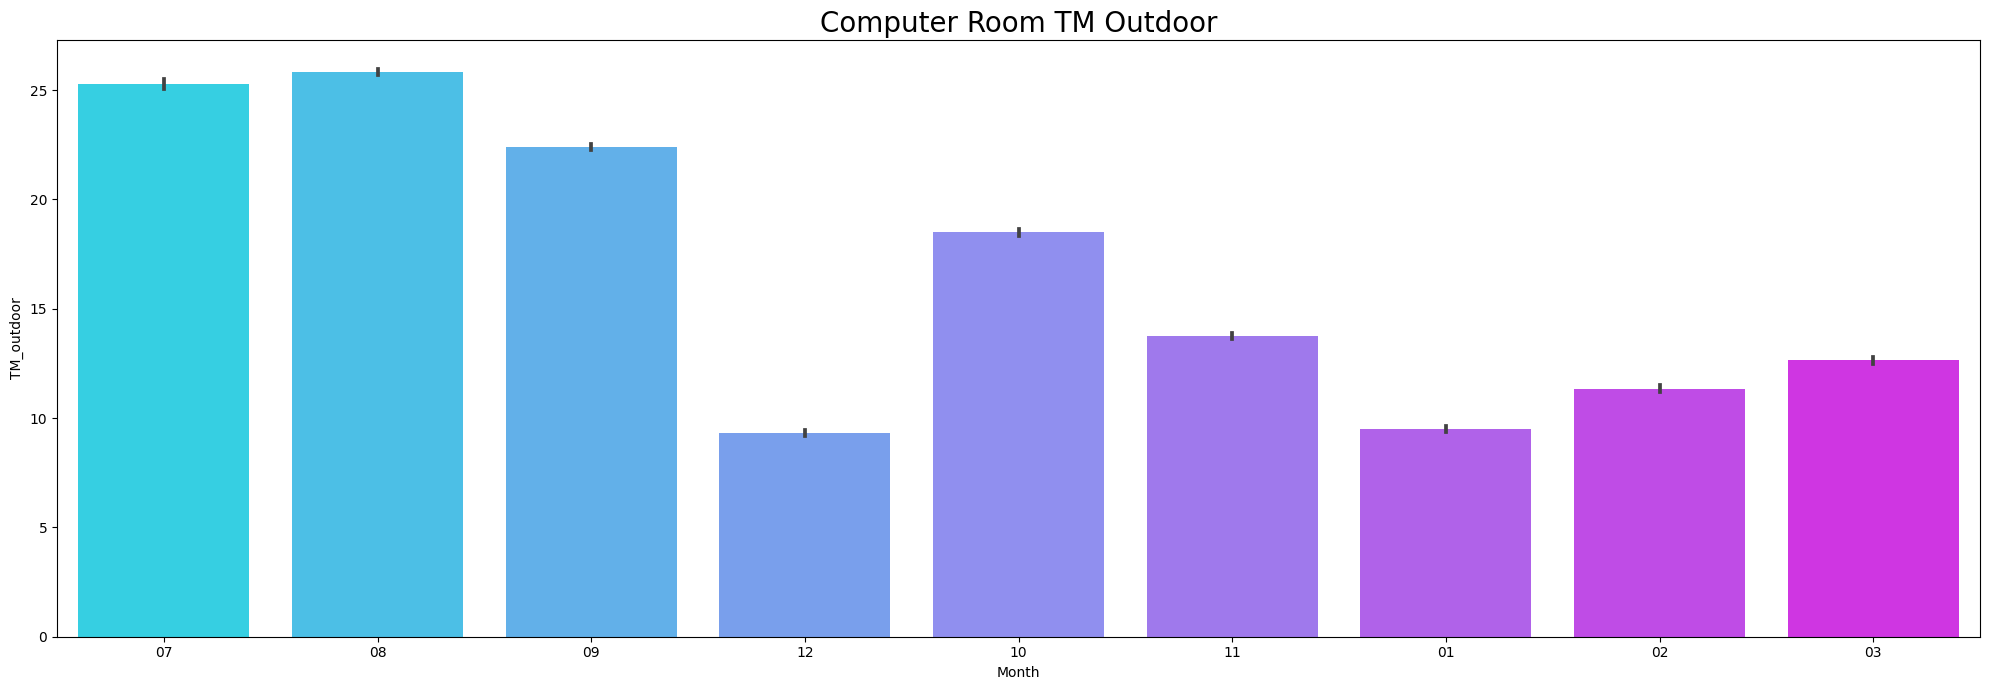

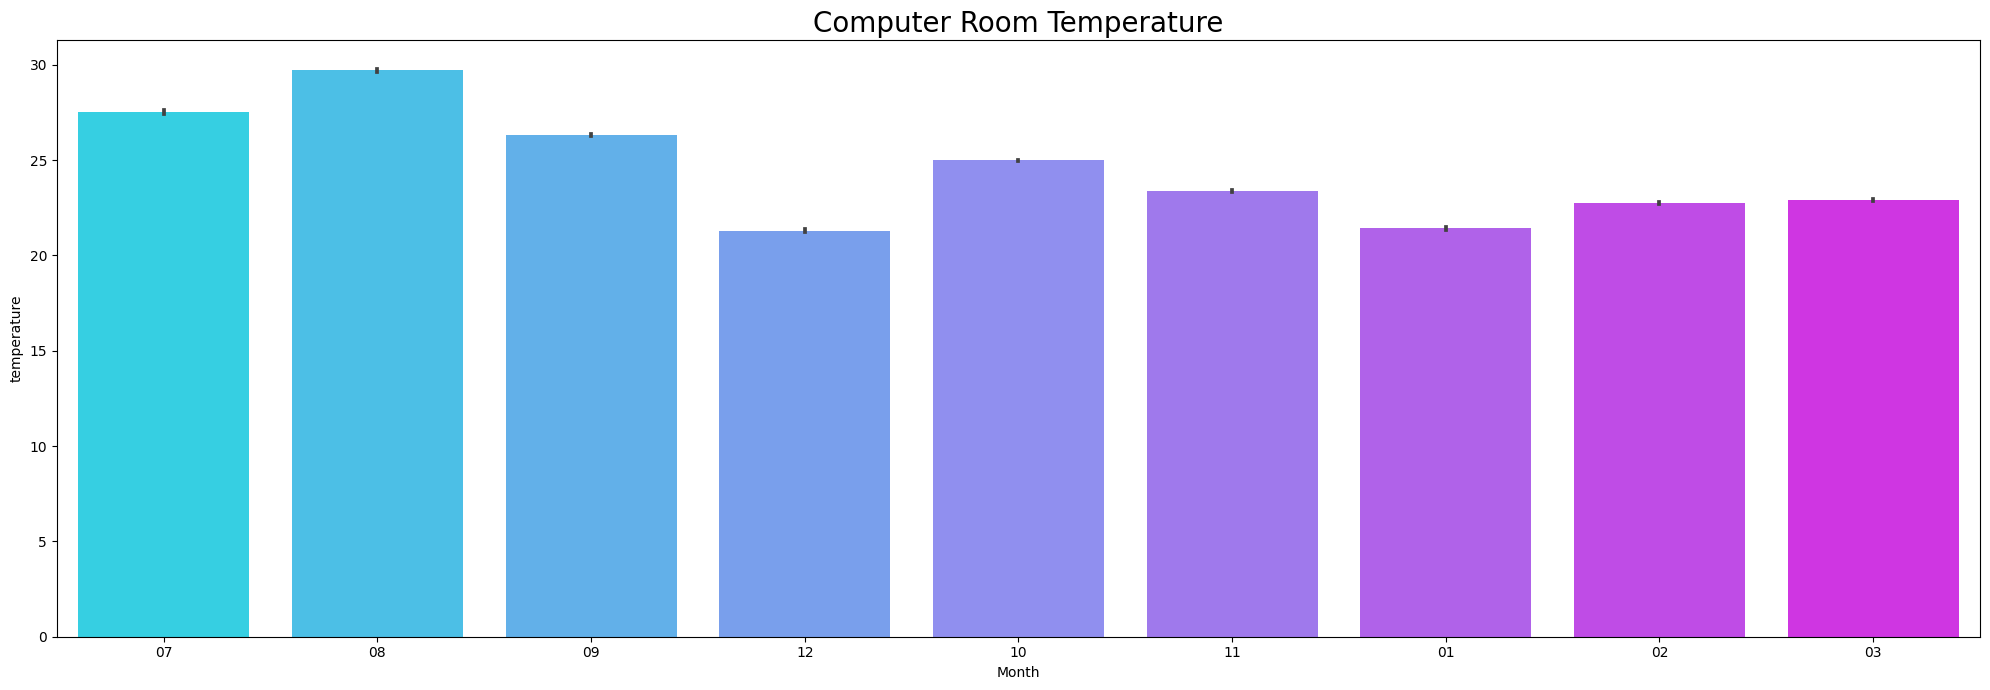

In [16]:
display_plot(Computer_Room_com, Computer_Room_com['Month'], Computer_Room_com['TM_outdoor'], "Computer Room TM Outdoor")
display_plot(Computer_Room_com, Computer_Room_com['Month'], Computer_Room_com['temperature'], "Computer Room Temperature")

In [17]:
# Test for normality, multimodality (Hartigan's Dip Test), and far outliers (Tukey's test)
table = TableOne(Computer_Room_com.drop(['Day', 'Month', 'Year','Hour', "Minutes", "o3"], axis = 1), dip_test=True, normal_test=True, tukey_test=True)
table

Missing        Overall
n                                             31489
Season, n (%)          0.0         0   11225 (35.6)
                       1.0              3355 (10.7)
                       2.0              5347 (17.0)
                       3.0             11562 (36.7)
Time_of_Day, n (%)     0.0         0    7940 (25.2)
                       1.0              5232 (16.6)
                       2.0              9196 (29.2)
                       3.0              9121 (29.0)
light_level, n (%)     0.0        14   23412 (74.4)
                       1.0              4313 (13.7)
                       2.0               1137 (3.6)
                       3.0                949 (3.0)
                       4.0               1664 (5.3)
co2, mean (SD)                     0   451.2 (90.4)
humidity, n (%)        22.0        0        1 (0.0)
                       22.5                 8 (0.0)
                       23.0                22 (0.1)
                       23.5                39 (0.1)
                       24.0                39 (0.1)
                       24.5                44 (0.1)
                       25.0                93 (0.3)
                       25.5               159 (0.5)
                       26.0               209 (0.7)
                       26.5               304 (1.0)
                       27.0               310 (1.0)
                       27.5               350 (1.1)
                       28.0               298 (0.9)
                       28.5               324 (1.0)
                       29.0               400 (1.3)
                       29.5               532 (1.7)
                       30.0               494 (1.6)
                       30.5               567 (1.8)
                       31.0               619 (2.0)
                       31.5               610 (1.9)
                       32.0               592 (1.9)
                       32.5               765 (2.4)
                       33.0               826 (2.6)
                       33.5               890 (2.8)
                       34.0               972 (3.1)
                       34.5               792 (2.5)
                       35.0               664 (2.1)
                       35.5               528 (1.7)
                       36.0               570 (1.8)
                       36.5               551 (1.7)
                       36.75                1 (0.0)
                       37.0               493 (1.6)
                       37.25                1 (0.0)
                       37.5               682 (2.2)
                       38.0               819 (2.6)
                       38.25                1 (0.0)
                       38.5               680 (2.2)
                       39.0               627 (2.0)
                       39.5               700 (2.2)
                       40.0               587 (1.9)
                       40.5               551 (1.7)
                       41.0               631 (2.0)
                       41.5               752 (2.4)
                       41.75                1 (0.0)
                       42.0               797 (2.5)
                       42.5               736 (2.3)
                       43.0               685 (2.2)
                       43.5               613 (1.9)
                       44.0               434 (1.4)
                       44.5               378 (1.2)
                       45.0               394 (1.3)
                       45.5               495 (1.6)
                       46.0               457 (1.5)
                       46.5               528 (1.7)
                       47.0               497 (1.6)
                       47.5               333 (1.1)
                       48.0               354 (1.1)
                       48.5               325 (1.0)
                       49.0               284 (0.9)
                       49.5               314 (1.0)
                       50.0               322 (1.0)
                       50

Tukey test indicates far outliers

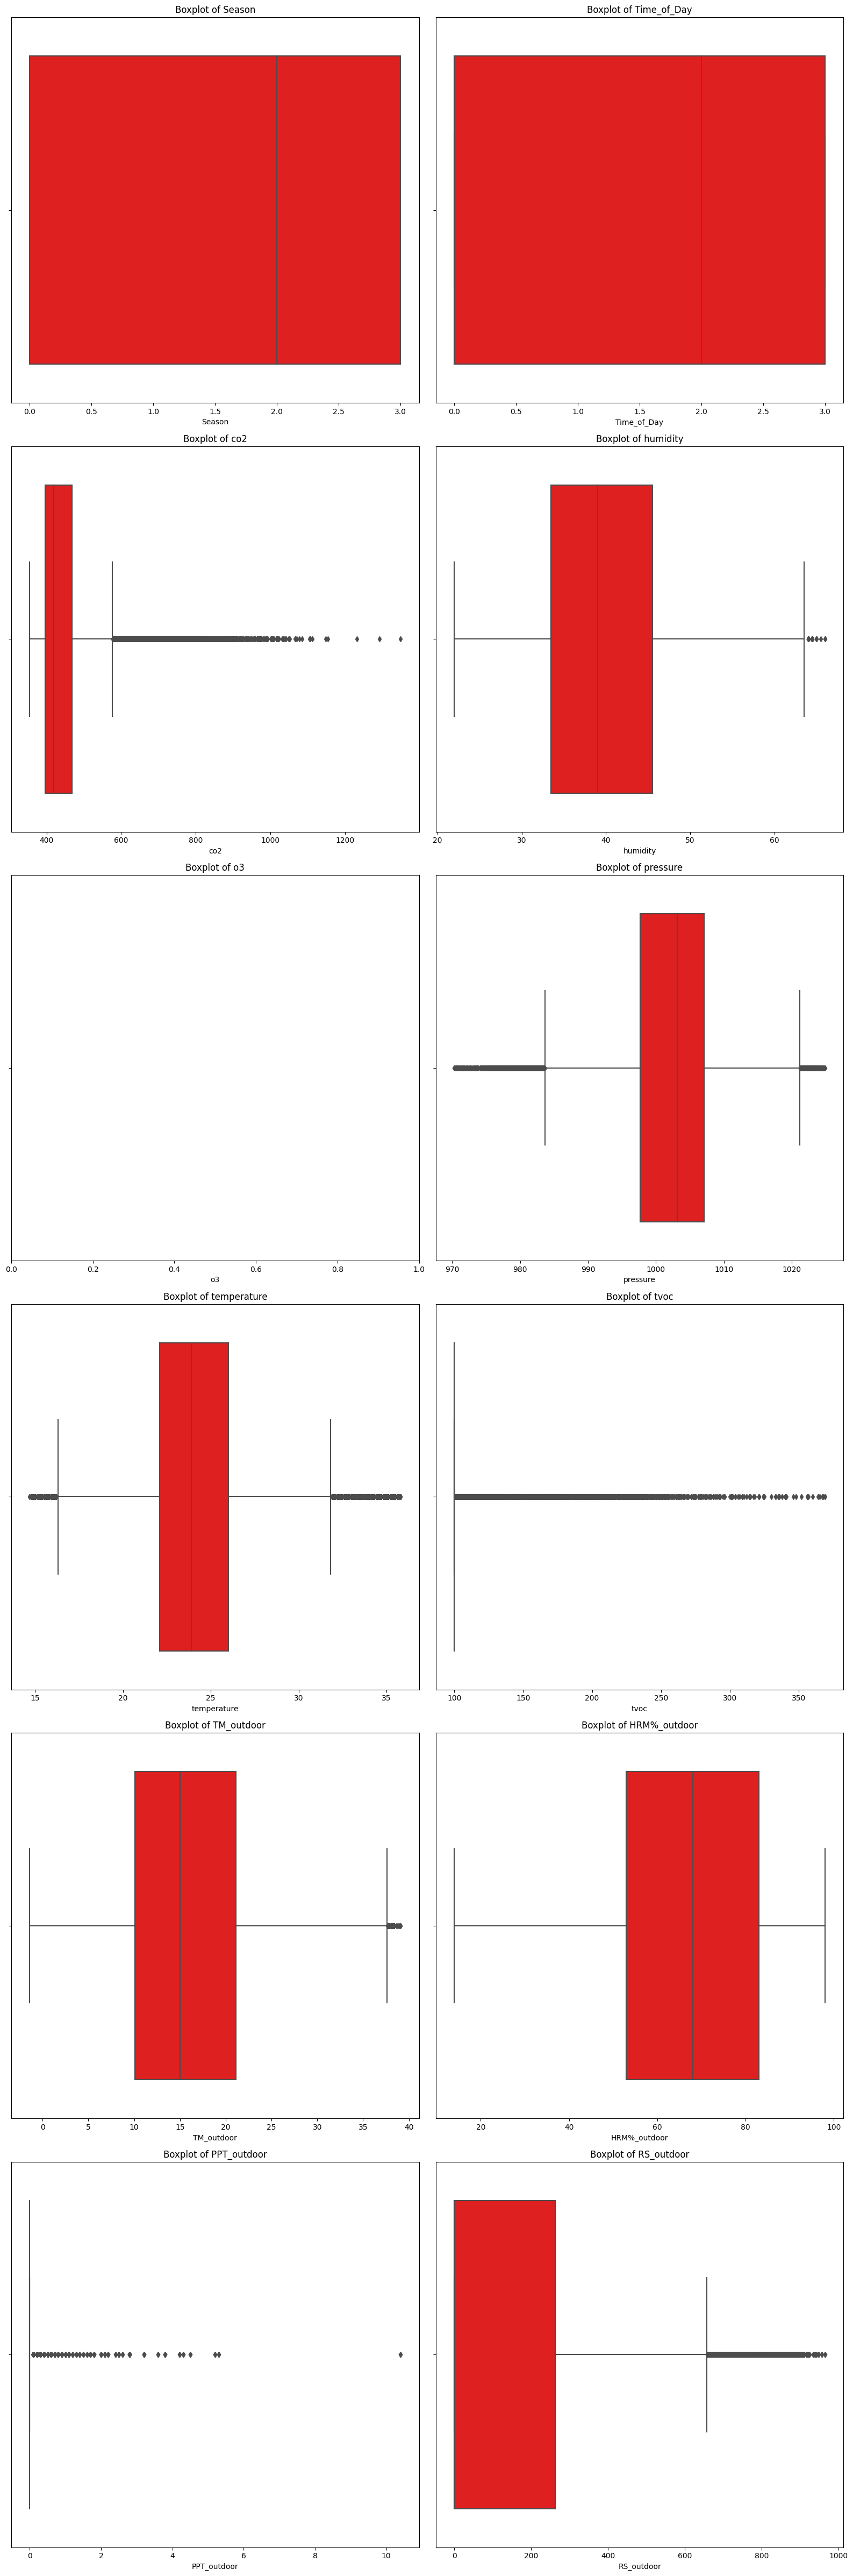

"Q1 = Computer_Room_com['co2'].quantile(0.25)\nQ3 = Computer_Room_com['co2'].quantile(0.75)\nIQR = Q3 - Q1\nlower_bound = Q1 - 1.5 * IQR\nupper_bound = Q3 + 1.5 * IQR\n\noutliers_co2 = Computer_Room_com[(Computer_Room_com['co2'] < lower_bound) | (Computer_Room_com['co2'] > upper_bound)]\n\noutliers_co2"

In [13]:
display_outliers(Computer_Room_com)
"""Q1 = Computer_Room_com['co2'].quantile(0.25)
Q3 = Computer_Room_com['co2'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_co2 = Computer_Room_com[(Computer_Room_com['co2'] < lower_bound) | (Computer_Room_com['co2'] > upper_bound)]

outliers_co2"""

Correlations

In [9]:
Computer_Room_com['Day'] = pd.to_numeric(Computer_Room_com['Day'])
Computer_Room_com['Month'] = pd.to_numeric(Computer_Room_com['Month'])
Computer_Room_com['Year'] = pd.to_numeric(Computer_Room_com['Year'])
Computer_Room_com['Hour'] = pd.to_numeric(Computer_Room_com['Hour'])
Computer_Room_com['Minutes'] = pd.to_numeric(Computer_Room_com['Minutes'])

<Axes: >

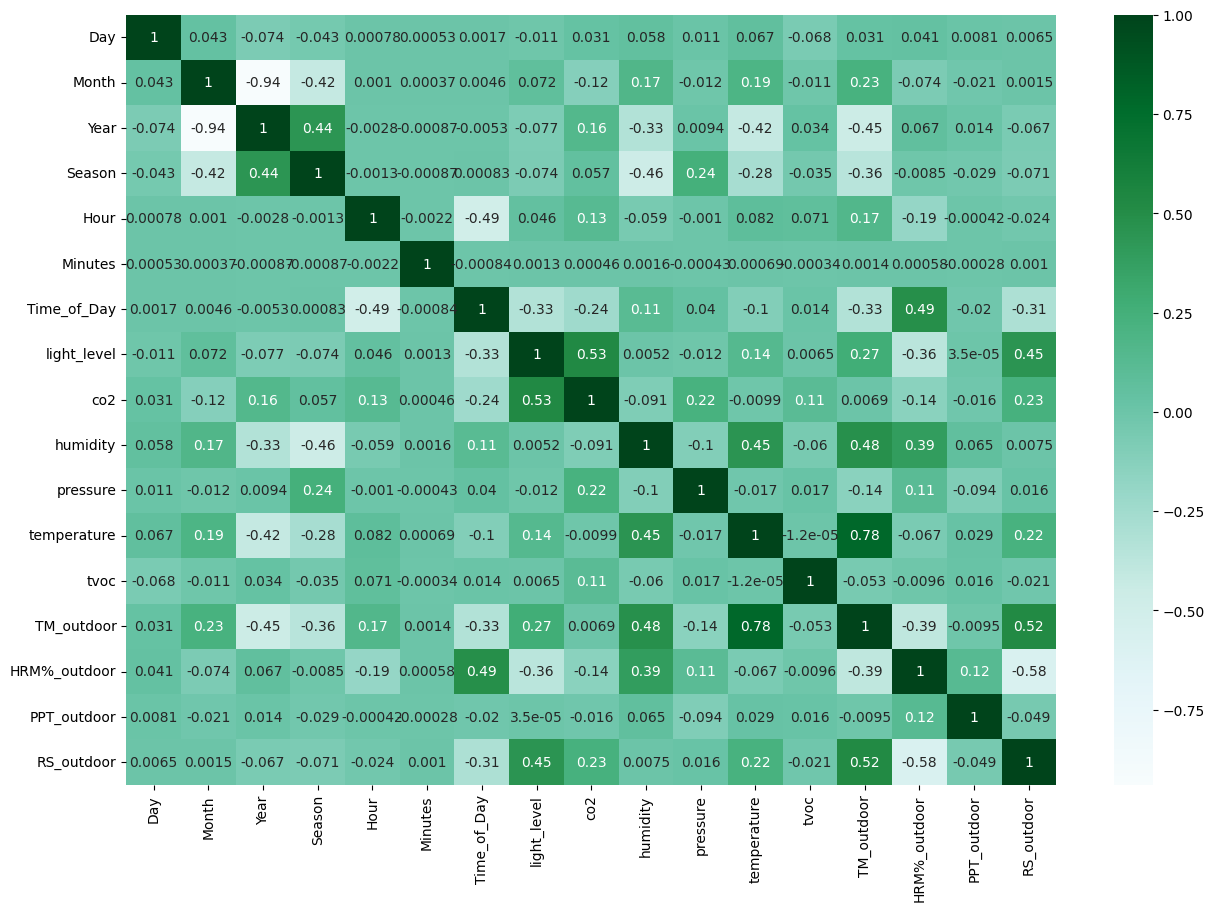

In [15]:
plt.figure(figsize=(15, 10))
sb.heatmap(Computer_Room_com.drop(['o3'], axis=1).corr(), cmap='BuGn', annot=True)

It can be seen that the columns co2, pressure, tvoc do not have a correlation with any of the other variables. This is because they are totally independent and are not affected by the others.

Since, for example, the CO2 and TVOC columns are variables related to the air quality of the room itself.

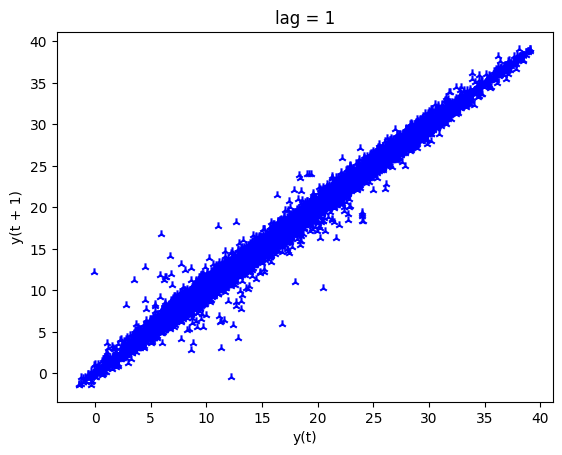

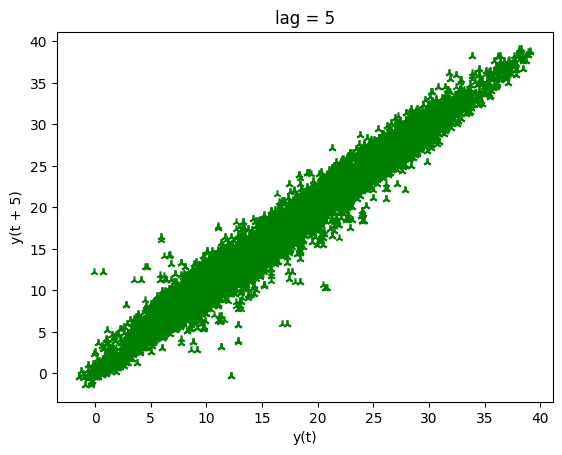

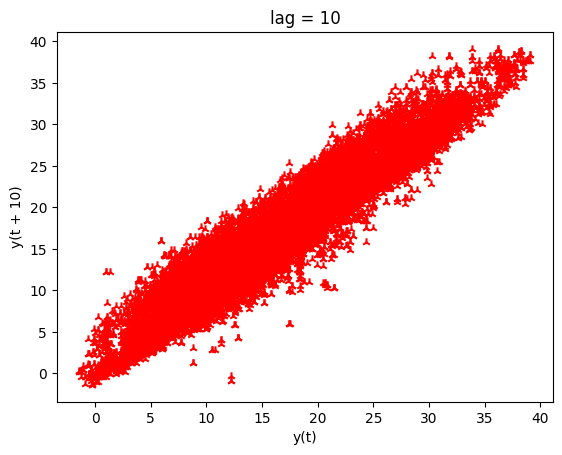

In [16]:
from pandas.plotting import lag_plot
plt.figure()
lag_plot(Computer_Room_com['TM_outdoor'], lag=1, marker='2', c='blue')
plt.title('lag = 1')
plt.figure()
lag_plot(Computer_Room_com['TM_outdoor'], lag=5, marker='2', c='green')
plt.title('lag = 5');
plt.figure()
lag_plot(Computer_Room_com['TM_outdoor'], lag=10, marker='2', c='red')
plt.title('lag = 10');

In [10]:
Computer_Room_com

,Day,Month,Year,Season,Hour,Minutes,Time_of_Day,light_level,co2,humidity,o3,pressure,temperature,tvoc,TM_outdoor,HRM%_outdoor,PPT_outdoor,RS_outdoor
0,25,7,2023,2.0,13,50,0.0,1.0,431.0,37.0,NaN,997.6,27.4,100.0,31.0,25,0.0,808
1,25,7,2023,2.0,14,0,0.0,1.0,426.0,37.0,NaN,997.5,27.5,100.0,31.0,25,0.0,808
2,25,7,2023,2.0,14,10,0.0,1.0,438.0,37.0,NaN,997.6,27.5,100.0,31.0,25,0.0,808
3,25,7,2023,2.0,14,20,0.0,1.0,425.0,37.0,NaN,997.6,27.5,100.0,31.2,25,0.0,746
4,25,7,2023,2.0,14,30,0.0,1.0,442.0,36.5,NaN,997.5,27.6,100.0,31.2,25,0.0,746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31484,30,3,2024,1.0,11,40,2.0,0.0,405.0,38.0,NaN,985.0,22.2,100.0,15.4,44,0.0,340
31485,30,3,2024,1.0,11,50,2.0,0.0,399.0,37.5,NaN,985.1,22.4,100.0,15.0,47,0.0,340
31486,30,3,2024,1.0,12,0,0.0,0.0,403.0,37.0,NaN,985.1,22.6,100.0,15.0,47,0.0,340
31487,30,3,2024,1.0,12,10,0.0,0.0,398.0,36.5,NaN,985.2,22.8,100.0,15.0,47,0.0,340


## Bidirectional and Unidirectional LSTM

In [11]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

class NNPredictionModel:
    def __init__(self, input_shape, output_units=3):
        self.temperature_model_1 = self.temp_uni_LSTM(input_shape, output_units)
        self.temperature_model_2 = self.temp_bi_LSTM(input_shape, output_units)
        self.temperature_model_3 = self.temp_uni2_LSTM(input_shape, output_units)
        self.co2_model_1 = self.co2_uni_LSTM(input_shape, output_units)
        self.co2_model_2 = self.co2_bi_LSTM(input_shape, output_units)

    def temp_uni_LSTM(self, input_shape, output_units):
        model = Sequential([
            LSTM(128, activation='tanh', return_sequences=True, input_shape=input_shape),
            Dropout(0.2),
            LSTM(64, activation='tanh', return_sequences=True),
            Dropout(0.2),
            LSTM(64, activation='tanh'),
            Dense(output_units, activation='linear')
        ])
        optimizer = Adam(learning_rate=0.0005)
        model.compile(optimizer=optimizer, loss='mse')
        return model
    
    def temp_uni2_LSTM(self, input_shape, output_units):
        model = Sequential([
            LSTM(128, activation='tanh', return_sequences=True, input_shape=input_shape, kernel_regularizer=l2(0.01)),
            Dropout(0.5),
            LSTM(64, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.01)),
            Dropout(0.5),
            LSTM(64, activation='tanh', kernel_regularizer=l2(0.01)),
            Dense(output_units, activation='linear')
        ])
        optimizer = Adam(learning_rate=0.0005)
        model.compile(optimizer=optimizer, loss='mse')
        return model

    def temp_bi_LSTM(self, input_shape, output_units):
        model_bi = Sequential([
            Bidirectional(LSTM(256, return_sequences=True), input_shape= input_shape),
            Dense(20, activation='tanh'),
            Bidirectional(LSTM(128,return_sequences=True, activation = 'tanh')),
            Dense(20, activation='tanh'),
            Bidirectional(LSTM(128,return_sequences=False, activation = 'tanh')),
            Dense(20, activation='tanh'),
            tf.keras.layers.Dropout(0.20),
            Dense(output_units, activation = 'linear'),
        ])
        model_bi.compile(optimizer='adam', loss='mse')
        return model_bi

    def co2_uni_LSTM(self, input_shape, output_units):
        model = Sequential([
            LSTM(128, activation='tanh', return_sequences=True, input_shape=input_shape, kernel_regularizer='l2'),
            BatchNormalization(),
            Dropout(0.3),
            LSTM(128, activation='tanh', return_sequences=True, kernel_regularizer='l2'),
            BatchNormalization(),
            Dropout(0.3),
            LSTM(64, activation='tanh', kernel_regularizer='l2'),
            BatchNormalization(),
            Dropout(0.3),
            Dense(output_units, activation='linear')
        ])
        optimizer = Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='mse')
        return model

    def co2_bi_LSTM(self, input_shape, output_units):
        model_bi = Sequential([
            Bidirectional(LSTM(256, return_sequences=True), input_shape= input_shape),
            Dense(20, activation='tanh'),
            BatchNormalization(),
            Dropout(0.3),
            Bidirectional(LSTM(128,return_sequences=True, activation = 'tanh')),
            Dense(20, activation='tanh'),
            BatchNormalization(),
            Dropout(0.3),
            Bidirectional(LSTM(128,return_sequences=False, activation = 'tanh')),
            Dense(20, activation='tanh'),
            BatchNormalization(),
            Dropout(0.3),
            #tf.keras.layers.Dropout(0.3),
            Dense(output_units, activation = 'linear'),
        ])
        model_bi.compile(optimizer='adam', loss='mse')
        return model_bi

In [28]:
def model_train_evaluation(y, X, model, model_name, label):
    #Model run
    from tensorflow.keras.callbacks import EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    #history = model.fit(X_train,y_train, epochs=6,validation_data=(X_val, y_val),callbacks=early_stop)
    history = model.fit(X_train,y_train, epochs=30,validation_split=0.001)#, callbacks=early_stop)
    history_frame = pd.DataFrame(history.history)
    
    # model performance plot
    plt.figure(figsize=(20,5))
    plt.plot(history.history['loss'], label='training loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='best')
    plt.title(model_name)
    plt.show()
    
    # Model Evaluation metrics
    from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score, r2_score, mean_absolute_percentage_error
    ypred =model.predict(X)
    print("\n \n Model Evaluation Report: ")
    print('Mean Absolute Error(MAE) of', model_name,':', mean_absolute_error(y, ypred))
    print('Mean Squared Error(MSE) of', model_name,':', mean_squared_error(y, ypred))
    print('Root Mean Squared Error (RMSE) of', model_name,':', mean_squared_error(y, ypred, squared = False))
    print('Mean absolute percentage error (MAPE) of', model_name,':', mean_absolute_percentage_error(y, ypred))
    print('Explained Variance Score (EVS) of', model_name,':', explained_variance_score(y, ypred))
    print('R2 of', model_name,':', (r2_score(y, ypred)).round(2))
    print('\n \n')
    
    # Actual vs Predicted Plot
    f, ax = plt.subplots(figsize=(12,6),dpi=100);
    plt.scatter(y, ypred, label="Actual vs Predicted")
    # Perfect predictions
    plt.xlabel(label)
    plt.ylabel(label)
    plt.title('Expection vs Prediction')
    plt.plot(y,y,'r', label="Perfect Expected Prediction")
    plt.legend()

    model.save('Models/'+model_name+'.h5')

## Temperature Prediction

In [95]:
df_train=Computer_Room_com[["Month","Hour","Minutes","light_level",'RS_outdoor', "TM_outdoor","temperature"]]
print(len(df_train.columns))

7


In [96]:
df_train

,Month,Hour,Minutes,light_level,RS_outdoor,TM_outdoor,temperature
0,7,13,50,1.0,808,31.0,27.4
1,7,14,0,1.0,808,31.0,27.5
2,7,14,10,1.0,808,31.0,27.5
3,7,14,20,1.0,746,31.2,27.5
4,7,14,30,1.0,746,31.2,27.6
...,...,...,...,...,...,...,...
31484,3,11,40,0.0,340,15.4,22.2
31485,3,11,50,0.0,340,15.0,22.4
31486,3,12,0,0.0,340,15.0,22.6
31487,3,12,10,0.0,340,15.0,22.8


In [97]:
print(df_train[df_train.columns[df_train.isnull().sum()>0]].isnull().sum())

light_level    14
dtype: int64


In [98]:
df_train = df_train.fillna(0)

In [99]:
print(df_train[df_train.columns[df_train.isnull().sum()>0]].isnull().sum())

Series([], dtype: float64)


In [100]:
df_train.to_csv("csv_train/Computer_Room_train_temp.csv", index=False)

In [101]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
scaler.fit(df_train)
df_train_scaled =scaler.transform(df_train)
df_train_scaled.shape

c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.h

(31489, 7)

In [102]:
lags=15
forecasts=1
X, y = [], []
for i in range(len(df_train_scaled) - forecasts-lags):
  X.append(df_train_scaled[i:(i + lags)])
  y.append(df_train_scaled[:,-1][i+lags: i+lags+ forecasts])
X,y =  np.array(X), np.array(y)
df_train_scaled.shape, X.shape, y.shape

((31489, 7), (31473, 15, 7), (31473, 1))

In [103]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((25178, 15, 7), (25178, 1), (6295, 15, 7), (6295, 1))

In [104]:
X_train, y_train, X_val, y_val

(array([[[ 0.19897416, -0.94147936, -0.29240887, ..., -0.52766471,
           1.32944889,  2.55867746],
         [ 0.19897416, -0.94147936,  0.29361855, ..., -0.52766471,
           1.32944889,  2.55867746],
         [ 0.19897416, -0.94147936,  0.87964597, ..., -0.52766471,
           1.32944889,  2.55867746],
         ...,
         [ 0.19897416, -0.65181675, -0.29240887, ...,  1.0628854 ,
           1.91008917,  2.82183566],
         [ 0.19897416, -0.65181675,  0.29361855, ...,  1.0628854 ,
           1.91008917,  2.82183566],
         [ 0.19897416, -0.65181675,  0.87964597, ...,  1.0628854 ,
           1.91008917,  2.85107546]],
 
        [[ 1.19913339,  0.94132758, -0.87843628, ..., -0.65300698,
          -0.59722113, -0.1606239 ],
         [ 1.19913339,  0.94132758, -0.29240887, ..., -0.65300698,
          -0.75557757, -0.1606239 ],
         [ 1.19913339,  0.94132758,  0.29361855, ..., -0.65300698,
          -0.75557757, -0.1898637 ],
         ...,
         [ 1.19913339,  1.2309901

In [105]:
n_steps = X_train.shape[-2]
n_features =X_train.shape[-1]
input_shape=(n_steps, n_features)

model = NNPredictionModel(input_shape, output_units=1)
uni_model = model.temperature_model_1
bi_model = model.temperature_model_2
uni2_model = model.temperature_model_3

bi_model.summary()
#tf.keras.utils.plot_model(bi_model)

uni_model.summary()
#tf.keras.utils.plot_model(uni_model)

c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_36                │ (None, 15, 512)        │       540,672 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 15, 20)         │        10,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_37                │ (None, 15, 256)        │       152,576 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 15, 20)         │         5,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_38                │ (None, 256)            │       152,576 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 20)             │         5,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 866,385 (3.30 MB)

 Trainable params: 866,385 (3.30 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_90 (LSTM)                  │ (None, 15, 128)        │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_91 (LSTM)                  │ (None, 15, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_92 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,129 (594.25 KB)

 Trainable params: 152,129 (594.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.0808 - val_loss: 0.0094
Epoch 2/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0102 - val_loss: 0.0032
Epoch 3/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0090 - val_loss: 0.0024
Epoch 4/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0065 - val_loss: 0.0012
Epoch 5/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.0058 - val_loss: 0.0046
Epoch 6/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.0063 - val_loss: 0.0012
Epoch 7/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.0057 - val_loss: 0.0011
Epoch 8/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.0055 - val_loss: 0.0011
Epoch 9/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.0056 - val_loss: 5.8534e-04
Epoch 10/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.0053 - val_loss: 6.9426e-04
Epoch 11/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0050 - val_loss: 7.1106e-04
Epoch 12/30
786/78

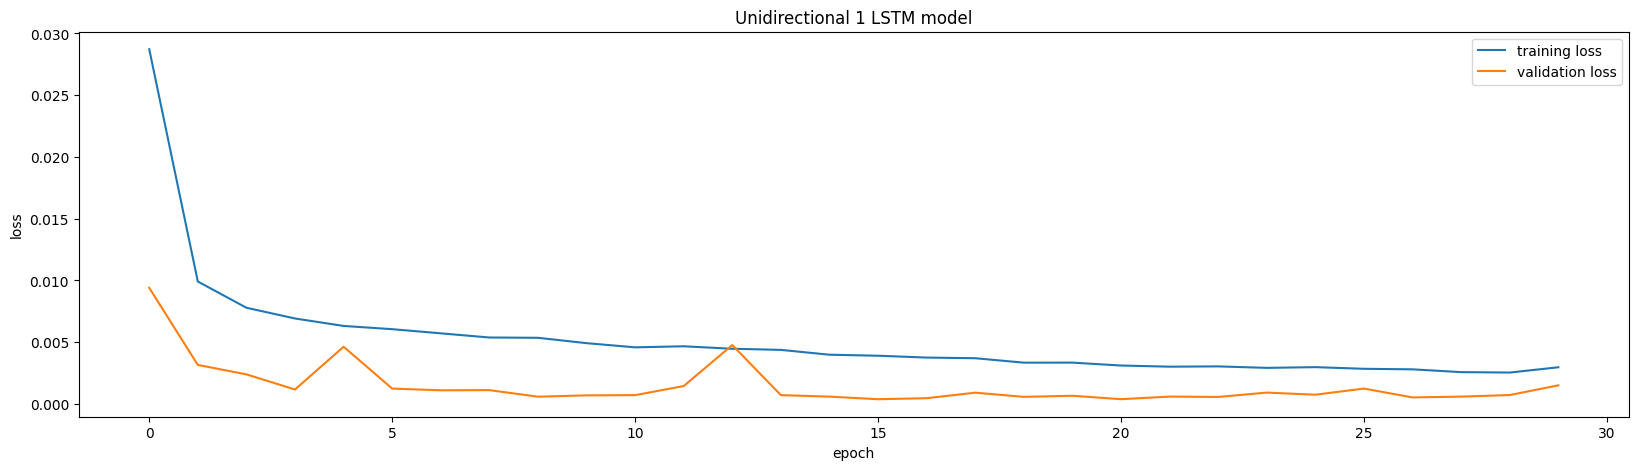

197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of Unidirectional 1 LSTM model : 0.034631471424364874
Mean Squared Error(MSE) of Unidirectional 1 LSTM model : 0.002641997077875772
Root Mean Squared Error (RMSE) of Unidirectional 1 LSTM model : 0.051400360678459954
Mean absolute percentage error (MAPE) of Unidirectional 1 LSTM model : 0.12596288479674334
Explained Variance Score (EVS) of Unidirectional 1 LSTM model : 0.9976421244634064
R2 of Unidirectional 1 LSTM model : 1.0

 



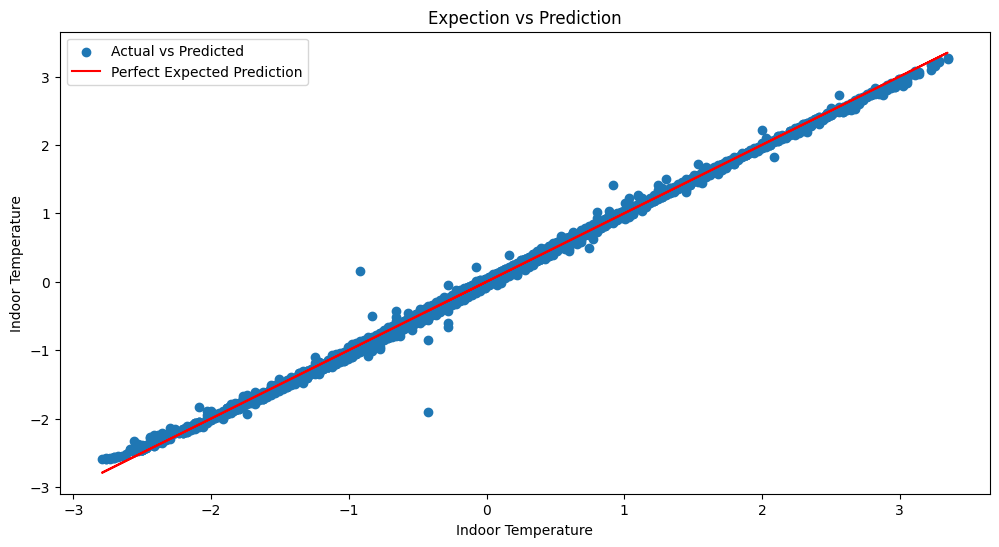

In [106]:
model_train_evaluation(y_val, X_val, uni_model, 'Unidirectional 1 LSTM model', 'Indoor Temperature')

In [107]:
#model_train_evaluation(y_val, X_val,bi_model, 'Bidirectional LSTM model', 'Indoor Temperature')

In [108]:
#model_train_evaluation(y_val, X_val, uni2_model, 'Unidirectional 2 LSTM model', 'Indoor Temperature')

## Quality-Air Prediction co2

In [113]:
df_train=Computer_Room_com[["Day",'Season',"Hour","Minutes","light_level","co2"]]
print(len(df_train.columns))#RS_outdoor

6


In [114]:
df_train

,Day,Season,Hour,Minutes,light_level,co2
0,25,2.0,13,50,1.0,431.0
1,25,2.0,14,0,1.0,426.0
2,25,2.0,14,10,1.0,438.0
3,25,2.0,14,20,1.0,425.0
4,25,2.0,14,30,1.0,442.0
...,...,...,...,...,...,...
31484,30,1.0,11,40,0.0,405.0
31485,30,1.0,11,50,0.0,399.0
31486,30,1.0,12,0,0.0,403.0
31487,30,1.0,12,10,0.0,398.0


In [115]:
print(df_train[df_train.columns[df_train.isnull().sum()>0]].isnull().sum())

light_level    14
dtype: int64


In [116]:
df_train = df_train.fillna(0)

In [117]:
print(df_train[df_train.columns[df_train.isnull().sum()>0]].isnull().sum())

Series([], dtype: float64)


In [118]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
scaler.fit(df_train)
df_train_scaled =scaler.transform(df_train)
df_train_scaled.shape

c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.h

(31489, 6)

In [119]:
lags=15
forecasts= 1
X, y = [], []
for i in range(len(df_train_scaled) - forecasts-lags):
  X.append(df_train_scaled[i:(i + lags)])
  y.append(df_train_scaled[:,-1][i+lags: i+lags+ forecasts])
X,y =  np.array(X), np.array(y)
df_train_scaled.shape, X.shape, y.shape

((31489, 6), (31473, 15, 6), (31473, 1))

In [120]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((25178, 15, 6), (25178, 1), (6295, 15, 6), (6295, 1))

In [121]:
n_steps = X_train.shape[-2]
n_features =X_train.shape[-1]
input_shape=(n_steps, n_features)

model = NNPredictionModel(input_shape, output_units=1)
uni_model = model.co2_model_1
bi_model = model.co2_model_2

bi_model.summary()
#tf.keras.utils.plot_model(bi_model)
uni_model.summary()
#tf.keras.utils.plot_model(uni_model)

c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_45                │ (None, 15, 512)        │       538,624 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 15, 20)         │        10,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 15, 20)         │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_85 (Dropout)            │ (None, 15, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_46                │ (None, 15, 256)        │       152,576 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 15, 20)         │         5,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 15, 20)         │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ (None, 15, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_47                │ (None, 256)            │       152,576 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 20)             │         5,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_87 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 864,577 (3.30 MB)

 Trainable params: 864,457 (3.30 MB)

 Non-trainable params: 120 (480.00 B)

Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_114 (LSTM)                 │ (None, 15, 128)        │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 15, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_115 (LSTM)                 │ (None, 15, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 15, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_116 (LSTM)                 │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_84 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 251,457 (982.25 KB)

 Trainable params: 250,817 (979.75 KB)

 Non-trainable params: 640 (2.50 KB)

In [122]:
model_train_evaluation(y_val, X_val, uni_model, 'Unidirectional 1 LSTM co2 model', 'Indoor co2')

Epoch 1/30
639/786 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 4.1882

KeyboardInterrupt: 

Epoch 1/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 40s 42ms/step - loss: 1.0179 - val_loss: 0.0496
Epoch 2/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - loss: 0.2000 - val_loss: 0.0253
Epoch 3/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - loss: 0.1477 - val_loss: 0.0292
Epoch 4/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - loss: 0.1443 - val_loss: 0.0328
Epoch 5/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - loss: 0.1388 - val_loss: 0.0243
Epoch 6/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - loss: 0.1171 - val_loss: 0.0261
Epoch 7/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - loss: 0.1219 - val_loss: 0.0274
Epoch 8/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 33s 41ms/step - loss: 0.1223 - val_loss: 0.0279
Epoch 9/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - loss: 0.1143 - val_loss: 0.0371
Epoch 10/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - loss: 0.1096 - val_loss: 0.0376
Epoch 11/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - loss: 0.1257 - val_loss: 0.0205
Epoch 12/30
786/786 ━━━━━━━━━━

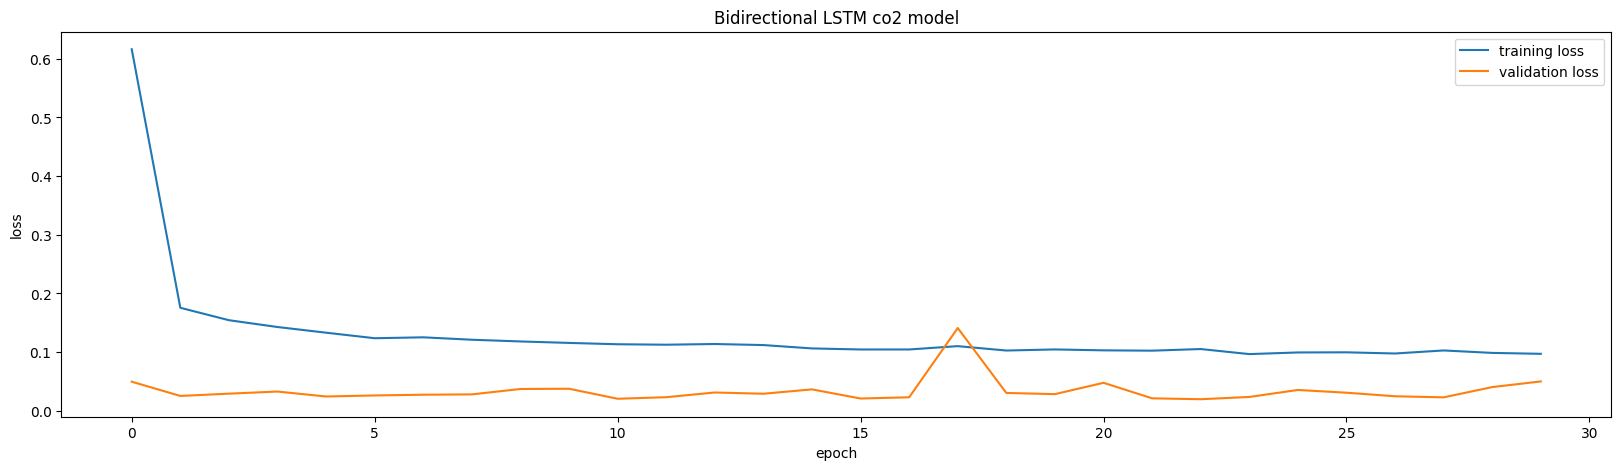

197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step


c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of Bidirectional LSTM co2 model : 0.20566450051639346
Mean Squared Error(MSE) of Bidirectional LSTM co2 model : 0.0879754999965641
Root Mean Squared Error (RMSE) of Bidirectional LSTM co2 model : 0.2966066418618506
Mean absolute percentage error (MAPE) of Bidirectional LSTM co2 model : 1.3939041990978354
Explained Variance Score (EVS) of Bidirectional LSTM co2 model : 0.9440292865352449
R2 of Bidirectional LSTM co2 model : 0.91

 



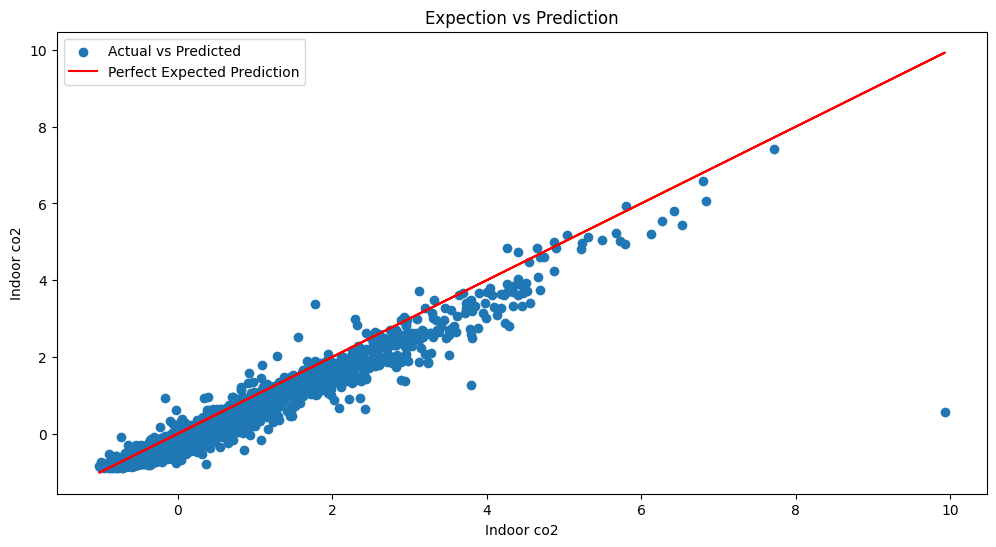

In [ ]:
model_train_evaluation(y_val, X_val, bi_model, 'Bidirectional LSTM co2 model', 'Indoor co2')

## Quality-Air Prediction tvoc

In [ ]:
df_train=Computer_Room_com[["Day","Hour","Minutes","Time_of_Day","light_level","tvoc"]]
print(len(df_train.columns))

6


In [ ]:
print(df_train[df_train.columns[df_train.isnull().sum()>0]].isnull().sum())

light_level    14
dtype: int64


In [ ]:
df_train = df_train.fillna(0)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
scaler.fit(df_train)
df_train_scaled =scaler.transform(df_train)
df_train_scaled.shape

c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.h

(31489, 6)

In [ ]:
lags=15
forecasts= 1
X, y = [], []
for i in range(len(df_train_scaled) - forecasts-lags):
  X.append(df_train_scaled[i:(i + lags)])
  y.append(df_train_scaled[:,-1][i+lags: i+lags+ forecasts])
X,y =  np.array(X), np.array(y)
df_train_scaled.shape, X.shape, y.shape

((31489, 6), (31473, 15, 6), (31473, 1))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((25178, 15, 6), (25178, 1), (6295, 15, 6), (6295, 1))

In [ ]:
n_steps = X_train.shape[-2]
n_features =X_train.shape[-1]
input_shape=(n_steps, n_features)

model = NNPredictionModel(input_shape, output_units=1)
uni_model = model.co2_model_1
bi_model = model.co2_model_2

#bi_model.summary()
#tf.keras.utils.plot_model(bi_model)
#uni_model.summary()
#tf.keras.utils.plot_model(uni_model)

c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: 3.6629 - val_loss: 1.0850
Epoch 2/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.7161 - val_loss: 0.4053
Epoch 3/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.3137 - val_loss: 0.4168
Epoch 4/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - loss: 0.2835 - val_loss: 0.2542
Epoch 5/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.2268 - val_loss: 0.3166
Epoch 6/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.2411 - val_loss: 0.3619
Epoch 7/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.2252 - val_loss: 0.2119
Epoch 8/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.2262 - val_loss: 0.2276
Epoch 9/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - loss: 0.2094 - val_loss: 0.2278
Epoch 10/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.1712 - val_loss: 0.2375
Epoch 11/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.2143 - val_loss: 0.3245
Epoch 12/30
786/786 ━━━━━━━━━━

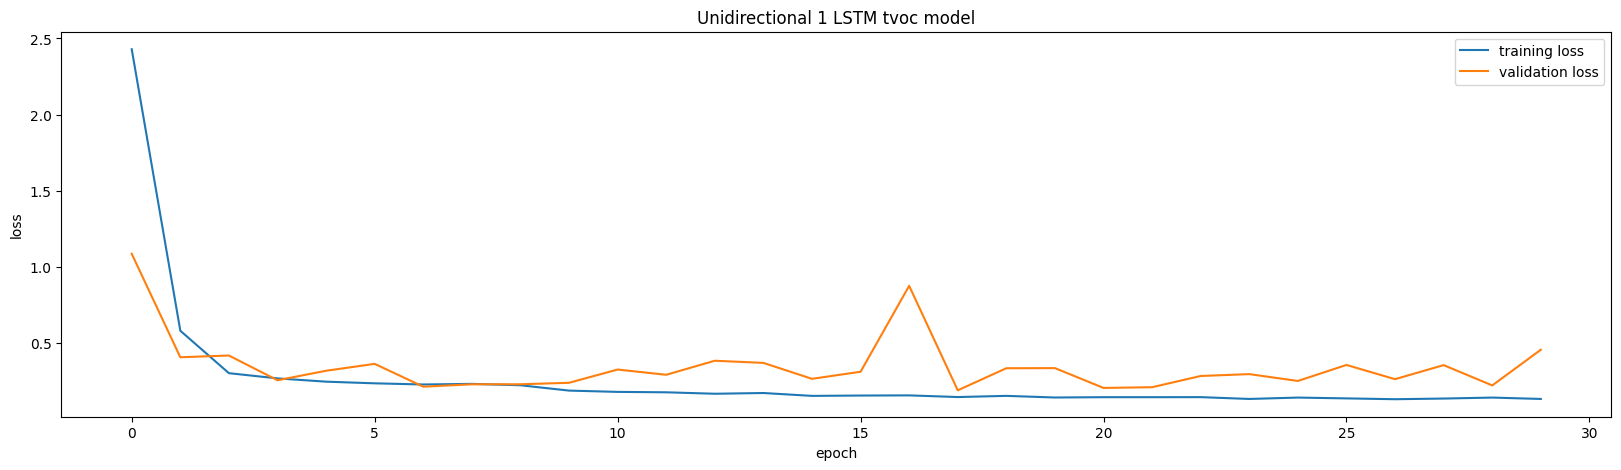

197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of Unidirectional 1 LSTM tvoc model : 0.2719999813892394
Mean Squared Error(MSE) of Unidirectional 1 LSTM tvoc model : 0.12922021898151098
Root Mean Squared Error (RMSE) of Unidirectional 1 LSTM tvoc model : 0.35947213936758854
Mean absolute percentage error (MAPE) of Unidirectional 1 LSTM tvoc model : 1.0592609651595517
Explained Variance Score (EVS) of Unidirectional 1 LSTM tvoc model : 0.9330922229595824
R2 of Unidirectional 1 LSTM tvoc model : 0.88

 



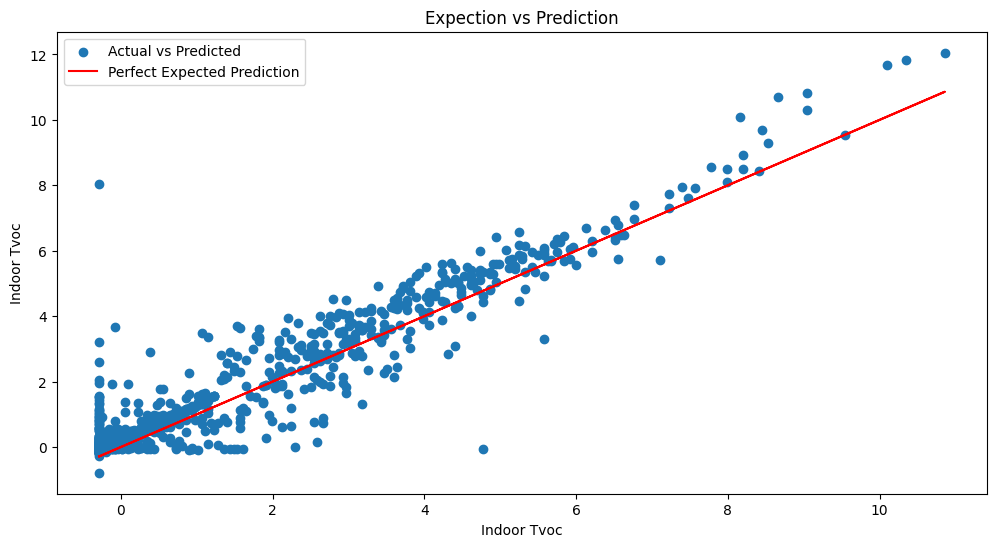

In [ ]:
model_train_evaluation(y_val, X_val, uni_model, 'Unidirectional 1 LSTM tvoc model', 'Indoor Tvoc')

Epoch 1/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - loss: 0.8322 - val_loss: 0.3917
Epoch 2/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - loss: 0.2242 - val_loss: 0.6666
Epoch 3/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - loss: 0.2031 - val_loss: 0.2655
Epoch 4/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - loss: 0.1707 - val_loss: 0.1717
Epoch 5/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 34s 43ms/step - loss: 0.1721 - val_loss: 0.2545
Epoch 6/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - loss: 0.1571 - val_loss: 0.2018
Epoch 7/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - loss: 0.1347 - val_loss: 0.2418
Epoch 8/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - loss: 0.1508 - val_loss: 0.2488
Epoch 9/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - loss: 0.1312 - val_loss: 0.4447
Epoch 10/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - loss: 0.1371 - val_loss: 0.3038
Epoch 11/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - loss: 0.1318 - val_loss: 0.1847
Epoch 12/30
786/786 ━━━━━━━━━━

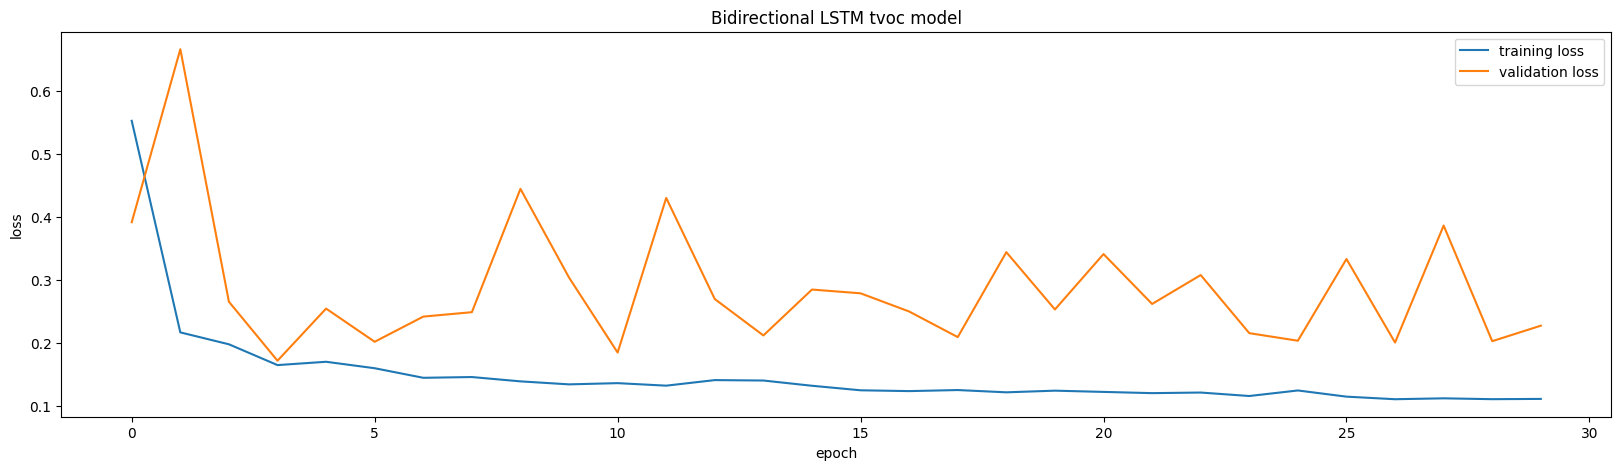

197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step


c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of Bidirectional LSTM tvoc model : 0.11667558323855336
Mean Squared Error(MSE) of Bidirectional LSTM tvoc model : 0.06979197756835898
Root Mean Squared Error (RMSE) of Bidirectional LSTM tvoc model : 0.26418171316039074
Mean absolute percentage error (MAPE) of Bidirectional LSTM tvoc model : 0.4411245943290357
Explained Variance Score (EVS) of Bidirectional LSTM tvoc model : 0.9359121616922714
R2 of Bidirectional LSTM tvoc model : 0.93

 



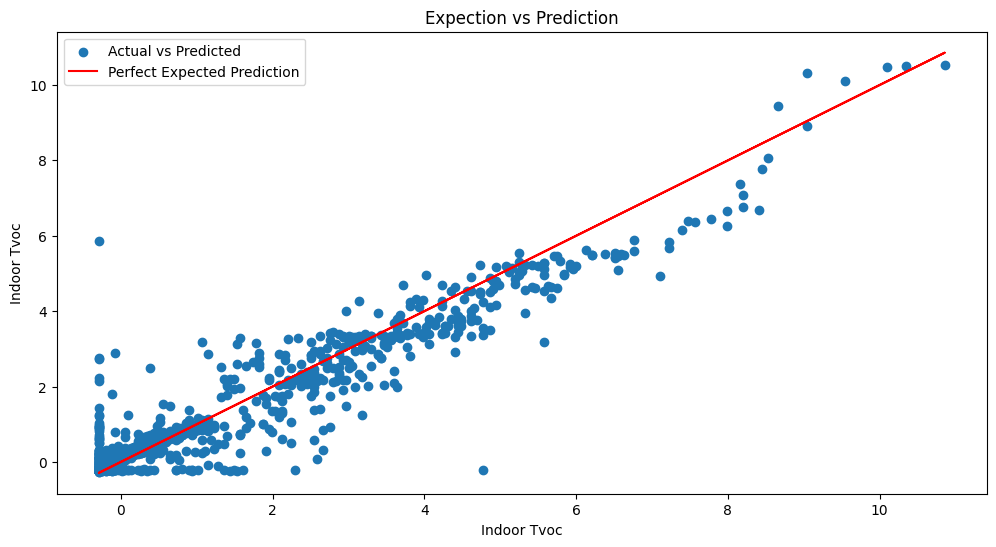

In [ ]:
model_train_evaluation(y_val, X_val, bi_model, 'Bidirectional LSTM tvoc model', 'Indoor Tvoc')

## Humidity Prediction

In [ ]:
df_train=Computer_Room_com[["Month","Day","Hour","Minutes","Time_of_Day","TM_outdoor", "HRM%_outdoor", "humidity"]]
print(len(df_train.columns))

8


In [ ]:
print(df_train[df_train.columns[df_train.isnull().sum()>0]].isnull().sum())

Series([], dtype: float64)


In [ ]:
df_train = df_train.fillna(0)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
scaler.fit(df_train)
df_train_scaled =scaler.transform(df_train)
df_train_scaled.shape

c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.h

(31489, 8)

In [ ]:
lags=15
forecasts=1
X, y = [], []
for i in range(len(df_train_scaled) - forecasts-lags):
  X.append(df_train_scaled[i:(i + lags)])
  y.append(df_train_scaled[:,-1][i+lags: i+lags+ forecasts])
X,y =  np.array(X), np.array(y)
df_train_scaled.shape, X.shape, y.shape

((31489, 8), (31473, 15, 8), (31473, 1))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((25178, 15, 8), (25178, 1), (6295, 15, 8), (6295, 1))

In [ ]:
n_steps = X_train.shape[-2]
n_features =X_train.shape[-1]
input_shape=(n_steps, n_features)

model = NNPredictionModel(input_shape, output_units=1)
uni_model = model.temperature_model_1
bi_model = model.temperature_model_2

bi_model.summary()
#tf.keras.utils.plot_model(bi_model)
uni_model.summary()
#tf.keras.utils.plot_model(uni_model)

c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_30                │ (None, 15, 512)        │       542,720 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 15, 20)         │        10,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_31                │ (None, 15, 256)        │       152,576 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 15, 20)         │         5,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_32                │ (None, 256)            │       152,576 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 20)             │         5,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 868,433 (3.31 MB)

 Trainable params: 868,433 (3.31 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_75 (LSTM)                  │ (None, 15, 128)        │        70,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_76 (LSTM)                  │ (None, 15, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_77 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,641 (596.25 KB)

 Trainable params: 152,641 (596.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.0822 - val_loss: 0.0149
Epoch 2/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0155 - val_loss: 0.0020
Epoch 3/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0123 - val_loss: 0.0065
Epoch 4/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0108 - val_loss: 0.0043
Epoch 5/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0089 - val_loss: 0.0032
Epoch 6/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0081 - val_loss: 0.0018
Epoch 7/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0073 - val_loss: 0.0018
Epoch 8/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0074 - val_loss: 0.0022
Epoch 9/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0079 - val_loss: 0.0018
Epoch 10/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0065 - val_loss: 0.0017
Epoch 11/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0058 - val_loss: 0.0013
Epoch 12/30
786/786 ━━━━━━━━━━

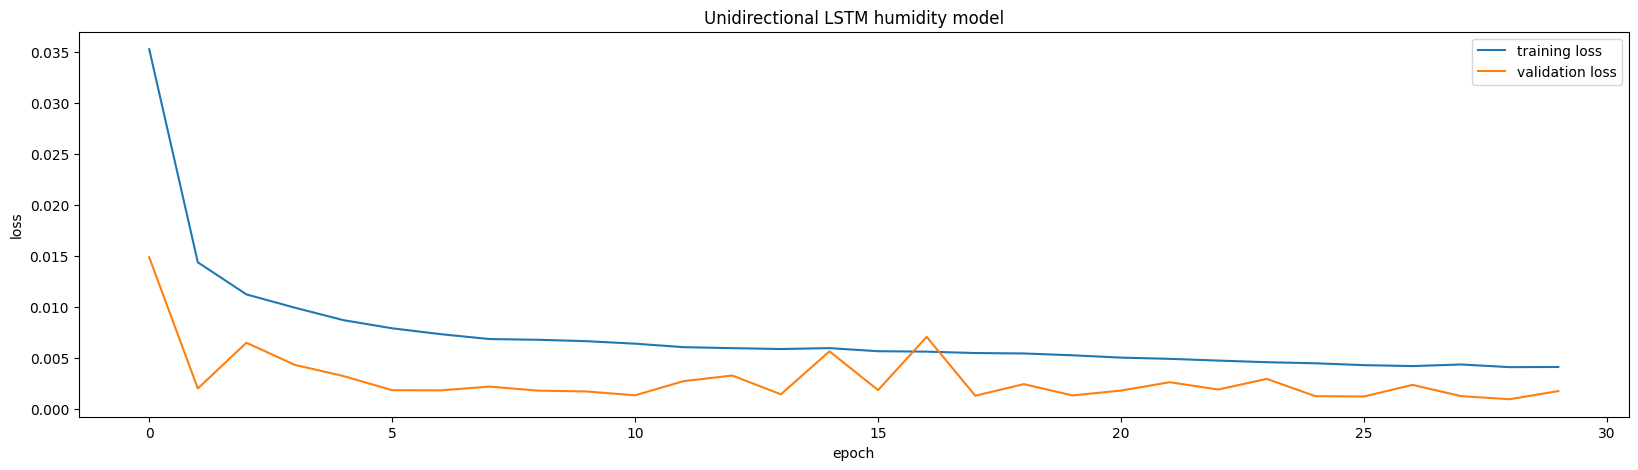

197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of Unidirectional LSTM humidity model : 0.03756569351377098
Mean Squared Error(MSE) of Unidirectional LSTM humidity model : 0.004101747207051827
Root Mean Squared Error (RMSE) of Unidirectional LSTM humidity model : 0.06404488431601565
Mean absolute percentage error (MAPE) of Unidirectional LSTM humidity model : 0.1581801448800994
Explained Variance Score (EVS) of Unidirectional LSTM humidity model : 0.9959568033584029
R2 of Unidirectional LSTM humidity model : 1.0

 



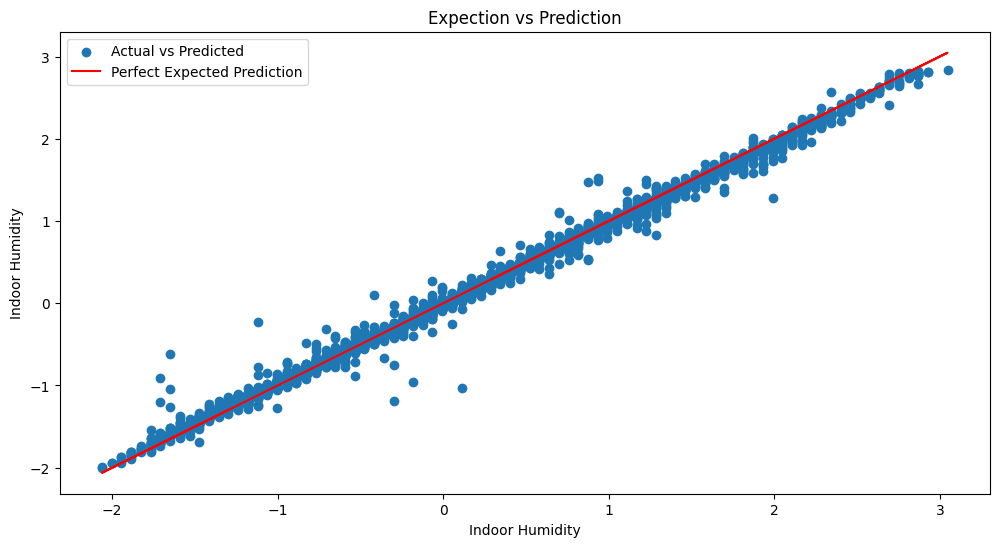

In [ ]:
model_train_evaluation(y_val, X_val, uni_model, 'Unidirectional LSTM humidity model', 'Indoor Humidity')

Epoch 1/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 36s 37ms/step - loss: 0.0721 - val_loss: 0.0056
Epoch 2/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - loss: 0.0240 - val_loss: 0.0086
Epoch 3/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - loss: 0.0219 - val_loss: 0.0030
Epoch 4/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - loss: 0.0202 - val_loss: 0.0080
Epoch 5/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - loss: 0.0196 - val_loss: 0.0034
Epoch 6/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - loss: 0.0192 - val_loss: 0.0031
Epoch 7/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - loss: 0.0198 - val_loss: 0.0032
Epoch 8/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - loss: 0.0193 - val_loss: 0.0023
Epoch 9/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - loss: 0.0190 - val_loss: 0.0028
Epoch 10/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - loss: 0.0175 - val_loss: 0.0085
Epoch 11/30
786/786 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - loss: 0.0170 - val_loss: 0.0020
Epoch 12/30
786/786 ━━━━━━━━━━

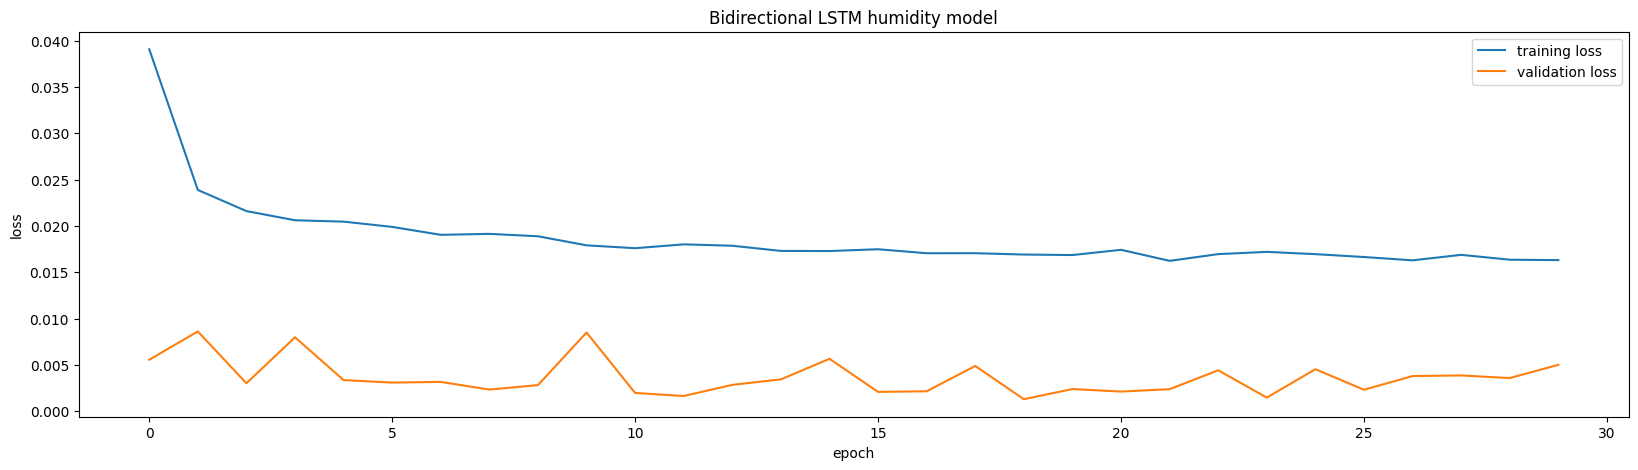

197/197 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step


c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of Bidirectional LSTM humidity model : 0.056203983904244185
Mean Squared Error(MSE) of Bidirectional LSTM humidity model : 0.006597339570320668
Root Mean Squared Error (RMSE) of Bidirectional LSTM humidity model : 0.08122400858318105
Mean absolute percentage error (MAPE) of Bidirectional LSTM humidity model : 0.20303704806074968
Explained Variance Score (EVS) of Bidirectional LSTM humidity model : 0.9935238970214332
R2 of Bidirectional LSTM humidity model : 0.99

 



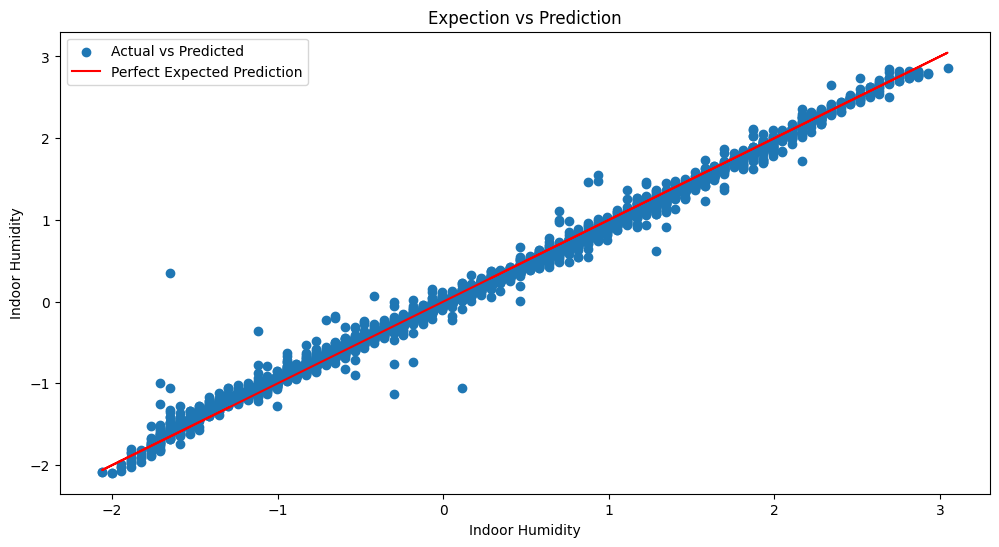

In [ ]:
model_train_evaluation(y_val, X_val, bi_model, 'Bidirectional LSTM humidity model', 'Indoor Humidity')